## This notebook makes a dummy storage curve as pretend validation data and calculates an r squared value compared to the depth to surface area made from the wofs/depth gauge method

In [14]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib
import matplotlib.pyplot as plt

In [2]:
my_storage_curve = 'Storage_curves/294.1.csv'

## Make some fake data

In [3]:
df = pd.read_csv(my_storage_curve)

# Get gauge ID
ID = df.loc[0, 'ID']

# Get first and last values
length = len(df)
last_n = length -1
last = df.iloc[last_n]
first = df.iloc[0]

last_v = last['Surface Area']
first_v = first['Surface Area']

# Change first and last values a little bit
first_v = first_v + (first_v * 0.05)
last_v = last_v - (last_v * 0.05)

# Change all values to 0 
df['Surface Area'] = 0

# Except for the first and last value
df.loc[0, 'Surface Area'] = first_v
df.loc[last_n, 'Surface Area'] = last_v

# Interpolate between the changed first and last values
df.drop(df[df['Surface Area'] == 0].index, inplace=True) #drop zero values
df2 = df.set_index("Depth")
min_ = df2.index.min()
max_ = df2.index.max()
df3 = df2.reindex(range(min_, max_+1))
df3['Surface Area'] = df3['Surface Area'].interpolate()
df3['ID'] = ID

## Compare with the real data

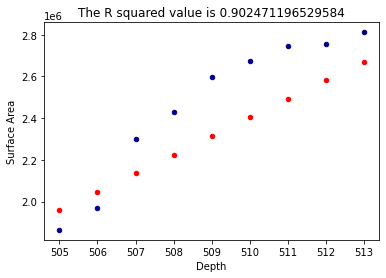

In [12]:
original = pd.read_csv(my_storage_curve, index_col='Depth')
fake = df3

#Calculate r squared
real_list = original['Surface Area'].to_list()
fake_list = fake['Surface Area'].to_list()

corr_matrix = np.corrcoef(real_list, fake_list)
corr = corr_matrix[0,1]
R2 = corr**2
R2_str = R2.astype(str)
title = 'The R squared value is ' + R2_str


# plot
original['Depth'] = original.index
fake['Depth'] = fake.index

ax = fake.plot.scatter(x='Depth',
                    y='Surface Area',
                    c='Red')
original.plot.scatter(x='Depth',
                    y='Surface Area',
                    c='DarkBlue',
                    ax=ax, title = title)

## Calculate Chi squared (mean difference)
We need to measure the difference between each point in the remotely sensed data and the 'validation' data, and then report the average difference.

In [39]:
contingency = pd.DataFrame(index=original.index)
contingency['Validation_Surface_Area'] = fake['Surface Area']
contingency['Remotley_Sensed_Surface_Area'] = original['Surface Area']
contingency['difference'] = contingency['Remotley_Sensed_Surface_Area'] - contingency['Validation_Surface_Area']
average_difference = sum(contingency['difference']/len(contingency.index))

print('The average difference between the remotley sensed data and the validation data is:')
print(average_difference)

The average difference between the remotley sensed data and the validation data is:
147210.06944444444
